In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt

import pandas
import numpy as np
from scipy import signal
from datetime import timedelta
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import minmax_scale
from scipy.signal import savgol_filter


def train_dataset():
    from glob import glob

    directory = glob('../data/train/aircraft/*.csv')
    train_files = list()

    # All train files are 5Hz, window size is 3 sec
    freq = 5
    window = freq * 3

    for name in directory:
        df = pandas.read_csv(name)
        df['h_speed'] = (df['velN']**2 + df['velE']**2) ** 0.5 * 3.6
        df['v_speed'] = df['velD'] * 3.6
        df['h_speed'] = savgol_filter(df['h_speed'], window, 0, mode='nearest')
        df['v_speed'] = savgol_filter(df['v_speed'], window, 0, mode='nearest')

        train_files.append(df)

    return pandas.concat(train_files)


# Aircraft classifier

In [3]:
df = train_dataset()
df['is_aircraft'] = (df['class'] == 4).astype('float')
df['gr'] = df['h_speed'] / df['v_speed']
df['gr'] = df['gr'].replace([np.inf, -np.inf], np.nan).bfill()

X_train = df[['h_speed', 'v_speed', 'gr']]
y_train = df['is_aircraft']

#aircraft_classifier = svm.SVC(kernel='rbf', gamma=0.01, C=10)
aircraft_classifier = DecisionTreeClassifier(criterion='entropy', max_depth=5)
aircraft_classifier.fit(X_train, y_train)

/usr/local/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [38]:
from sklearn.model_selection import GridSearchCV, KFold

kf = KFold(n_splits=5)

tree_params = {
    'criterion':['gini','entropy'],
    'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]
}                    

print("# Tuning hyper-parameters for accuracy")

clf = GridSearchCV(DecisionTreeClassifier(), tree_params, cv=kf,
                   scoring='accuracy')
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()   

# Tuning hyper-parameters for accuracy
Best parameters set found on development set:

{'criterion': 'entropy', 'max_depth': 5}

Grid scores on development set:

0.909 (+/-0.204) for {'criterion': 'gini', 'max_depth': 4}
0.910 (+/-0.203) for {'criterion': 'gini', 'max_depth': 5}
0.909 (+/-0.206) for {'criterion': 'gini', 'max_depth': 6}
0.908 (+/-0.205) for {'criterion': 'gini', 'max_depth': 7}
0.911 (+/-0.198) for {'criterion': 'gini', 'max_depth': 8}
0.910 (+/-0.198) for {'criterion': 'gini', 'max_depth': 9}
0.910 (+/-0.203) for {'criterion': 'gini', 'max_depth': 10}
0.911 (+/-0.199) for {'criterion': 'gini', 'max_depth': 11}
0.910 (+/-0.202) for {'criterion': 'gini', 'max_depth': 12}
0.909 (+/-0.198) for {'criterion': 'gini', 'max_depth': 15}
0.910 (+/-0.196) for {'criterion': 'gini', 'max_depth': 20}
0.909 (+/-0.196) for {'criterion': 'gini', 'max_depth': 30}
0.910 (+/-0.193) for {'criterion': 'gini', 'max_depth': 40}
0.910 (+/-0.194) for {'criterion': 'gini', 'max_depth': 50}
0.909

       class      duration_s  \
group                          
2        1.0 00:10:55.600000   

                                                     idx         segment_end  
group                                                                         
2      DatetimeIndex(['2016-10-23 21:11:23.400000', '... 2016-10-23 21:07:59  
2016-10-23 21:13:49.600000


<IPython.core.display.Javascript object>


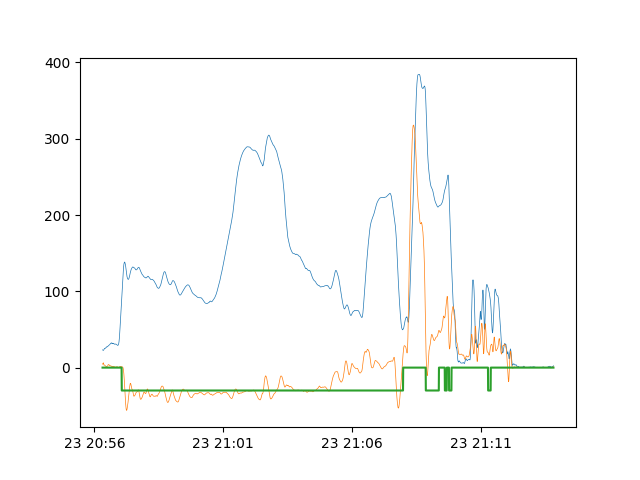

In [19]:
from datetime import timedelta
from sklearn.externals import joblib

aircraft_classifier = joblib.load('../aircraft_model.pkl')

def predict_and_show(filename):
    df = pandas.read_csv('../data/test/' + filename)
    df['time'] = pandas.to_datetime(df['time'])
    df['prev_time'] = df.shift()['time']
    df['time_diff'] = df['time'] - df['prev_time']

    most_used_freq = df['time_diff'].value_counts().index.values[0]
    freq = 1000 / most_used_freq.astype('timedelta64[ms]').astype('float')
    window_size = int(freq * 3)

    df.set_index('time', inplace=True)

    df['h_speed'] = (df['velN']**2 + df['velE']**2) ** 0.5 * 3.6
    df['v_speed'] = df['velD'] * 3.6

    df['h_speed'] = signal.savgol_filter(df['h_speed'], window_size, 0, mode='nearest')
    df['v_speed'] = signal.savgol_filter(df['v_speed'], window_size, 0, mode='nearest')
    
    df['gr'] = df['h_speed'] / df['v_speed']
    df['gr'] = df['gr'].replace([np.inf, -np.inf], np.nan).bfill()

    df['is_aircraft'] = aircraft_classifier.predict(df[['h_speed', 'v_speed', 'gr']])
    df['is_aircraft'] = df['is_aircraft'].rolling(window='5s').median()
    
    def group_details(x):
        return pandas.Series({
            'class': x.iloc[0].is_aircraft, 
            'idx': x.index,
            'segment_end': x.index[-1],
            'duration_s': x.index[-1] - x.index[0]
        })
        
    df['group'] = df['is_aircraft'].diff().ne(0).cumsum()        
    segments = df.groupby('group').apply(group_details).sort_values('duration_s')
    segments = segments[segments['class'] == 1.0]
    segments = segments[segments['duration_s'] > timedelta(minutes=1)]

    print(segments)
    print(segments.iloc[0].idx[-1])
    
    plt.figure()
    plt.plot(df['h_speed'], linewidth=0.5)
    plt.plot(df['v_speed'], linewidth=0.5)
    plt.plot(df['is_aircraft'] * -30)



predict_and_show('#7990 15-56-18.CSV')
#predict_and_show('Skydive Med WS 2 labeled.csv')
#predict_and_show('Base Big WS labeled.csv')

#predict_and_show('#703 14-41-39.CSV')
#predict_and_show('#RWL 13-41-49.CSV')
#predict_and_show('#RWL 20-19-40.csv')
#predict_and_show('#RWL 17-16-43.csv')
#predict_and_show('#1838 15-54-47.CSV')


plt.show()

In [31]:
from sklearn import tree
tree.export_graphviz(aircraft_classifier, out_file='tree.dot') 